In [7]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']
struct_axis = data['ax']
struct_slope = data['cs']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype
dtype_axis = struct_axis.dtype
dtype_slope = struct_slope.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}
data_axis = {n: struct_axis[n][0, 0] for n in dtype_axis.names}
data_slope = {n: struct_slope[n][0, 0] for n in dtype_slope.names}

obs_lat_s = data_south['lat_adcp'][0,:]
obs_lon_s = data_south['lon_adcp'][0,:]
obs_z_s = data_south['z_adcp'][:, 0]
obs_u_s = data_south['u'][:]
obs_v_s = data_south['v'][:]


obs_lat_n = data_north['lat_adcp'][0,:]
obs_lon_n = data_north['lon_adcp'][0,:]
obs_z_n = data_north['z_adcp'][:, 0]
obs_u_n = data_north['u'][:]
obs_v_n = data_north['v'][:]

obs_lat_x = data_axis['lat_adcp'][0,:]
obs_lon_x = data_axis['lon_adcp'][0,:]
obs_z_x = data_axis['z'][:, 0]
obs_u_x = data_axis['u'][:]
obs_v_x = data_axis['v'][:]

obs_lat_p = data_slope['lat_adcp'][0,:]
obs_lon_p = data_slope['lon_adcp'][0,:]
obs_z_p = data_slope['z_adcp'][:, 0]
obs_u_p = data_slope['u'][:]
obs_v_p = data_slope['v'][:]

In [3]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_U')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vozocrtx'][time_s:time_f,:,y,x]
        depth = ds.variables['depthu'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        mask0 = dsM.variables['umask'][0,:,y,x]

    mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)
    
    return vel, mask, depth, nav_lon, nav_lat

In [4]:
def reduce_list(any_list, number_of_values_to_combine):
    ret_list = []
    for i in range(len(any_list)//number_of_values_to_combine):
        new_value = 0
        for j in range(number_of_values_to_combine):
            new_value += any_list[i*number_of_values_to_combine + j]
        ret_list.append(new_value/number_of_values_to_combine)
    return ret_list

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_baseAW/'
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
time_s = 24
time_f = time_s+48

vozocrtx, umask, depthu, nav_lon, nav_lat = get_vels(dirname, fname, meshmaskname, time_s, time_f)
vozocrtx_daily = np.mean(vozocrtx, axis=0)
umask_daily = np.mean(umask, axis=0)

f_u = interpolate.interp1d(depthu, vozocrtx_daily, axis=0)
f_m = interpolate.interp1d(depthu, umask_daily, axis=0)

mod_u = f_u(obs_z_s)
mod_mask = f_m(obs_z_s)

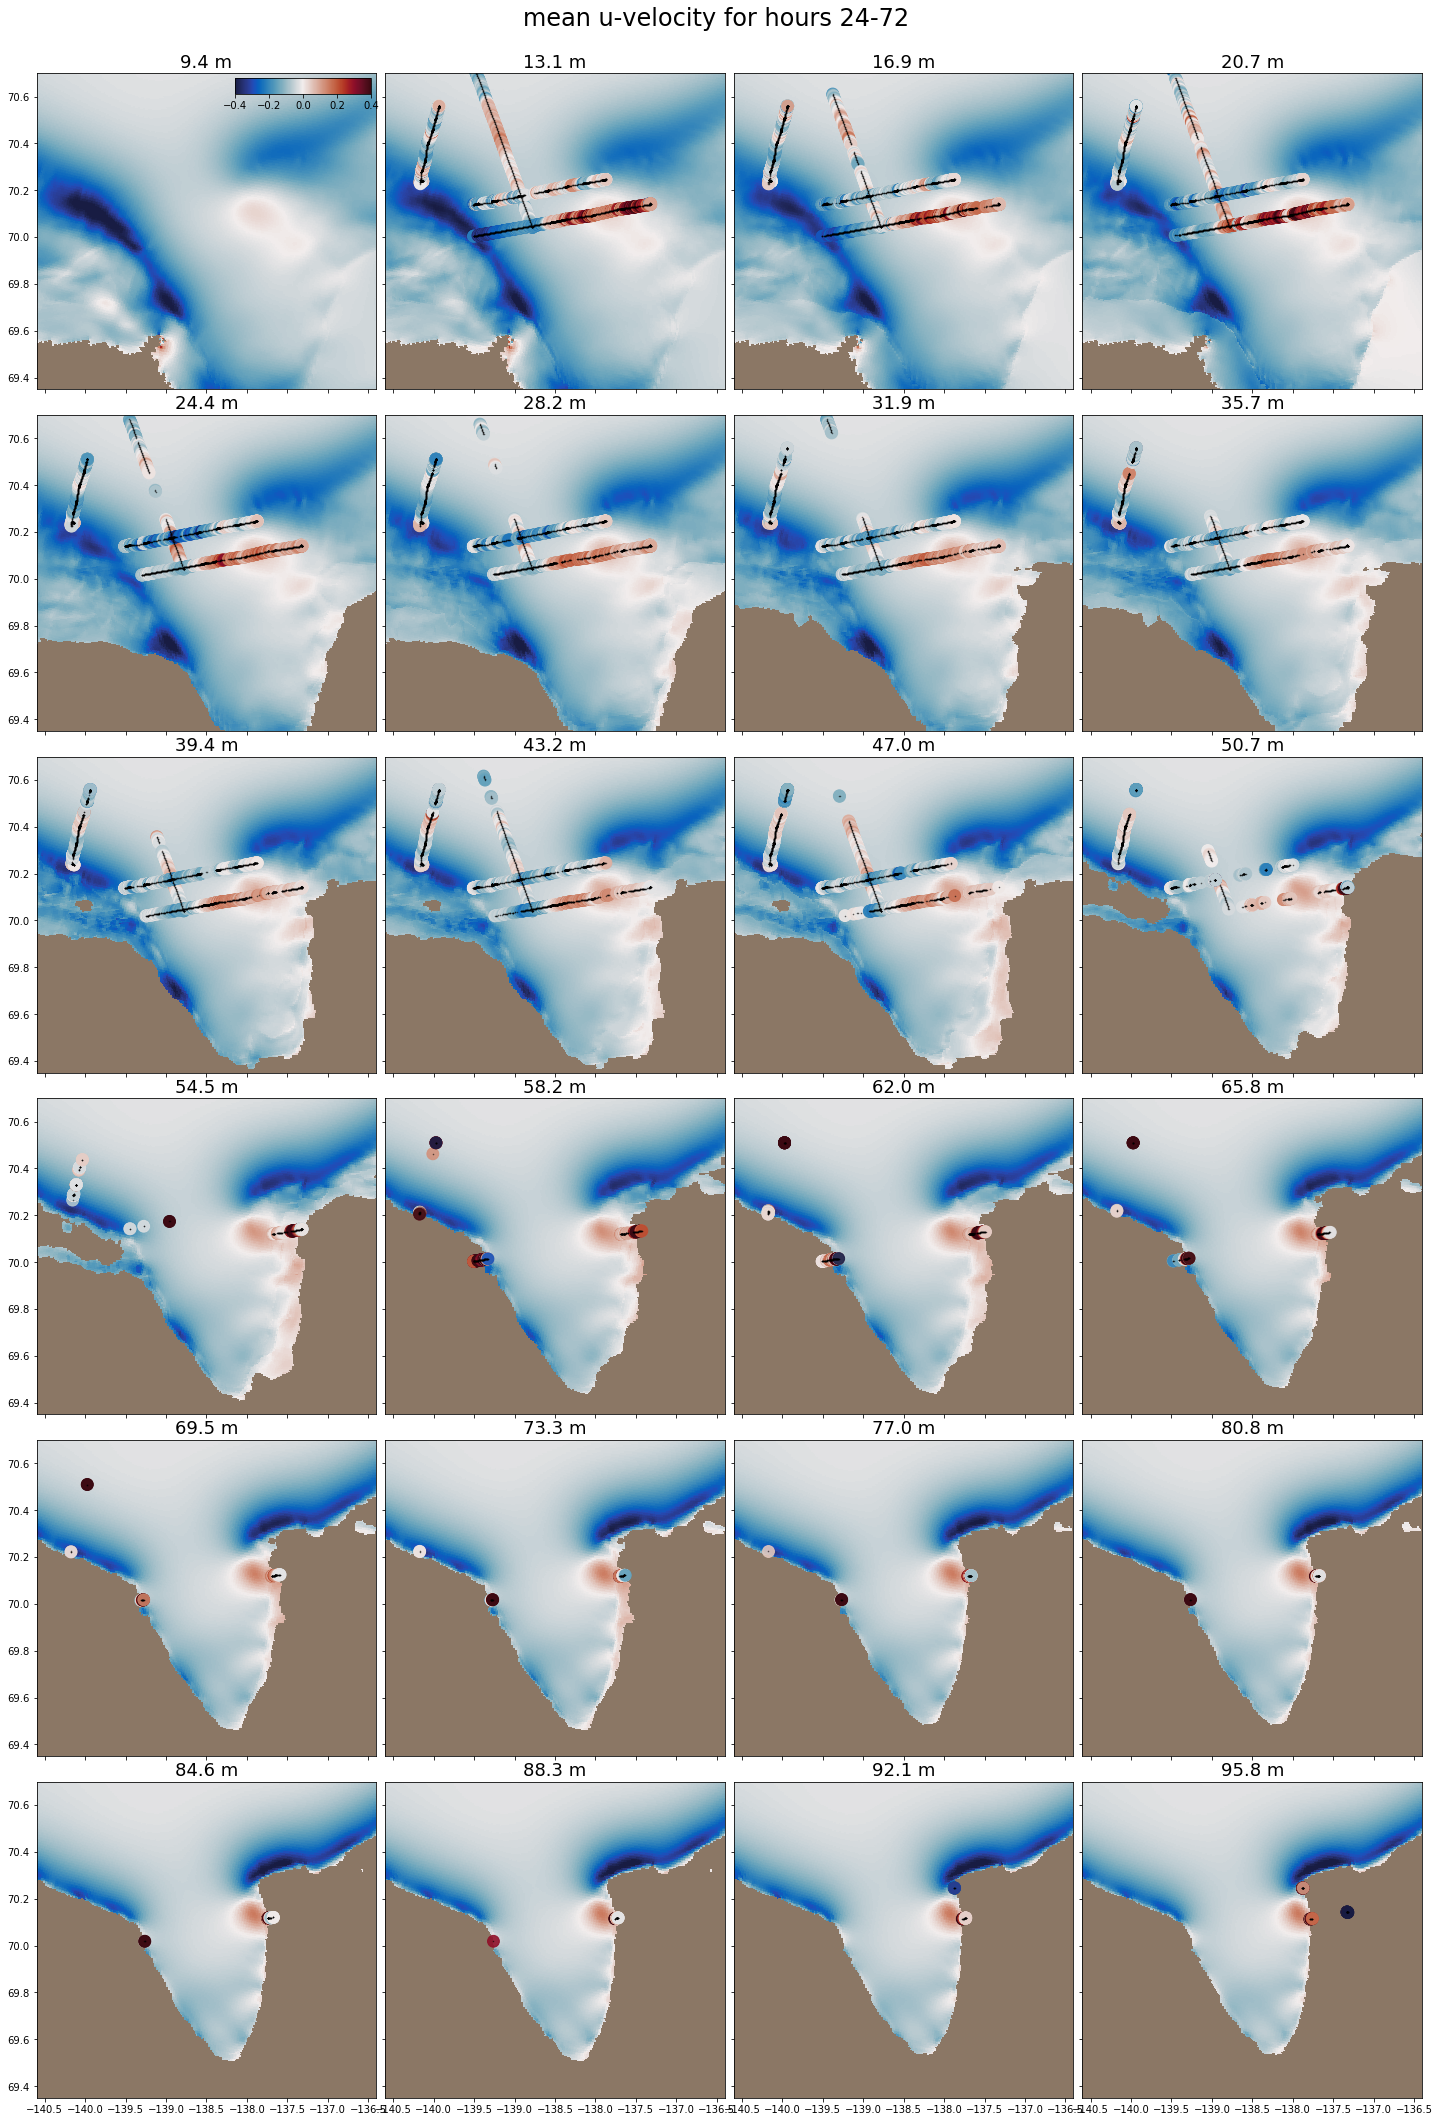

In [8]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), sharex=True, sharey=True)
for ax, n in zip(axes.flatten(), np.arange(24)):
    cmap = cmo.cm.balance
    cmap.set_bad('#8b7765')
    vmin, vmax = -0.4, 0.4
    
    plot_mod_u = np.ma.array(mod_u[n, :, :], mask=1 - mod_mask[n, :, :])
    p = ax.pcolormesh(nav_lon, nav_lat, plot_mod_u, vmin=vmin, vmax=vmax, cmap=cmap)
    
    obs_lon_list = [obs_lon_n, obs_lon_s, obs_lon_x, obs_lon_p]
    obs_lat_list = [obs_lat_n, obs_lat_s, obs_lat_x, obs_lat_p]
    obs_u_list   = [  obs_u_n,   obs_u_s,   obs_u_x,   obs_u_p]
    zos = [4, 3, 2, 1]
    
    for obs_lon, obs_lat, obs_u, zo in zip(obs_lon_list, obs_lat_list, obs_u_list, zos):
        ax.scatter(obs_lon, obs_lat, c=obs_u[n, :], 
                   s=140, edgecolors=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.9, zorder=zo)

        for i in range(len(obs_lon)):
            if np.isnan(obs_u[n, i]) == False:
                ax.scatter(obs_lon[i], obs_lat[i], c='k', s=0.3, zorder=5, alpha=0.6)
            else:
                pass

    ax.set_title(str(np.round(obs_z_s[n],1))+' m', fontsize=18)
    ax.set_xlim([-140.6, -136.4])
    ax.set_ylim([69.35, 70.7])
    w=1/math.cos(math.radians(69.8))
    ax.set_aspect(w)
    
    if n ==0:
        axins = inset_axes(ax,
                        width="40%",  # width = 10% of parent_bbox width
                        height="5%",  # height : 50%
                        loc=1)
        axins.xaxis.set_ticks_position("bottom")
        cb = fig.colorbar(p, cax=axins, orientation='horizontal')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
    
fig.tight_layout(w_pad=0.2, h_pad=0.7)
plt.subplots_adjust(top=0.95)
fig.suptitle('mean u-velocity for hours ' + str(time_s) + '-'+ str(time_f), fontsize=24)
fig.patch.set_facecolor('white') 
fig.savefig('./uvel_comparison_interp.png', dpi=150, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())